<a href="https://colab.research.google.com/github/Alienor1268/portfolio/blob/main/fish_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **FISH CLASSIFIER**

Fish classification is an important topic nowadays in fields such as agriculture, or in the marine world (for example for balancing fish supply in the ecosystem). As underlined in this article: https://www.sciencedirect.com/science/article/pii/S1319157820304195 , different fish classification  techniques enables researchers to develop and improve modelling methods. 


The dataset can be found on kaggle: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset and has been issued by: 
O.Ulucan, D.Karakaya, and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification.
In Conf. Innovations Intell. Syst. Appli. (ASYU)

Thanks to machine learning mmodels,reserrachers can develop a fish classifier.  
This can be for example implemented by using a framework such tensorflows. Users can train easily machine learning models for pictures recognition. 

## set up

In [20]:
! pip install -q kaggle

In [21]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (5).json


{'kaggle.json': b'{"username":"goussainvil28","key":"e3034926389e4cfbafe521aed82b03db"}'}

In [22]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


## Load the dataset and libraries

In [17]:
! kaggle datasets download -d crowww/a-large-scale-fish-dataset
!  unzip a-large-scale-fish-dataset.zip

a-large-scale-fish-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  a-large-scale-fish-dataset.zip
replace Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import tensorflow as tf

from pathlib import Path

These libraries are easy to use that's why they have been chosen for implementing the fish classifier. 

## loading an preprocessing the dataset


In [ ]:
directory = Path.cwd()/'Fish_Dataset/Fish_Dataset'
filepaths = list(directory.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))

filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)

img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()
#https://www.kaggle.com/code/fahadmehfoooz/fish-analysis

FilePaths           Labels
0  /content/Fish_Dataset/Fish_Dataset/Trout/Trout...            Trout
1  /content/Fish_Dataset/Fish_Dataset/Black Sea S...  Black Sea Sprat
2  /content/Fish_Dataset/Fish_Dataset/Shrimp/Shri...           Shrimp
3  /content/Fish_Dataset/Fish_Dataset/Gilt-Head B...  Gilt-Head Bream
4  /content/Fish_Dataset/Fish_Dataset/Red Sea Bre...    Red Sea Bream

### Have a look at an image...



In order to better analyze the dataset, it can be interesting to have a look a the fish pictures. It can be easy to view on the display by using Imshow and Imread.

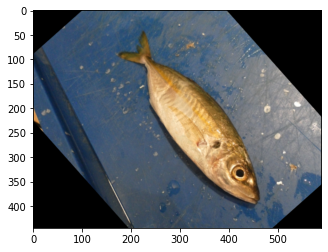

In [ ]:
# show hourse mackerel - picture 29
direc1 = Path.cwd()/'Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png'
img_1 = plt.imshow(plt.imread(direc1))

Red Sea Bream
/content/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream/00043.png


Text(0.5, 1.0, 'Red Sea Bream')

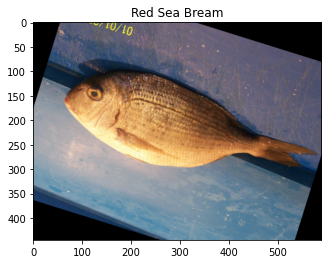

In [ ]:
#select a random picture
import PIL
x = img_df.sample()
random_category = x.Labels.values[0]
random_file_name = x.FilePaths.values[0]
print(random_category)
print(random_file_name)
img = PIL.Image.open(random_file_name)
plt.imshow(img)
plt.title(random_category)

An image can be selected randomly and display on the google colab platform!
The PIL Library enables to manipulate images. 

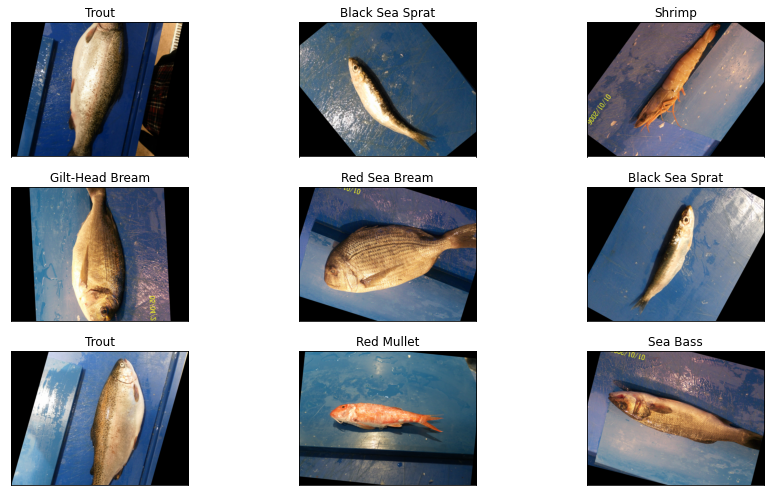

In [ ]:
# Show 9 images 
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()

### Labels

The 9 classes which represent the 9 fish categories are well balanced with 1000 pictures in each category. Class imbalance won't be a problem, and that's why, trying to forecast fish categories can be a  good option, the modelling phase should work well. 

In [ ]:
img_df['Labels'].value_counts(ascending=True)

Trout                 1000
Black Sea Sprat       1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Red Mullet            1000
Sea Bass              1000
Striped Red Mullet    1000
Hourse Mackerel       1000
Name: Labels, dtype: int64

## Modelling 

### Split the dataset 

In [ ]:
train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15

x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)
print(f'Shape of Validation Data : ',x_val.shape)
x_testt = x_test.copy()

Shape of Training Data :  (6750, 2)
Shape of Testing Data :  (1350, 2)
Shape of Validation Data :  (900, 2)


The training set is important to train the chosen model, the validation set allows to optimize the hyperparameters, and the test set allows to obtain an unbiased accuracy. Here the training is set to 75%, the validation ratio to 10% and the test set to 15%.


### data generator

In [ ]:
img_datagenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)    

x_train = img_datagenerator.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagenerator.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagenerator.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


The Keras Image generator used for data augmentation is based on  preprocess_inputs parent modules. the generator doen't need to be clearly define, it is already preprogrammed. 
The image generator allows to increase the dataset by creating new images, which will improve the accuracy of the trained models. 

It is possible to take a manually set image generator (like datagen below). 

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

img_size=(224, 224)    

x_train = train_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = train_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = train_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

AttributeError: ignored

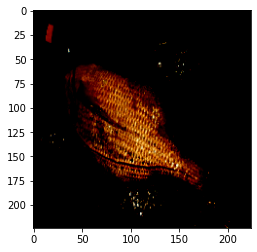

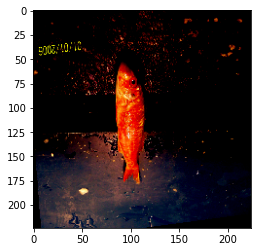

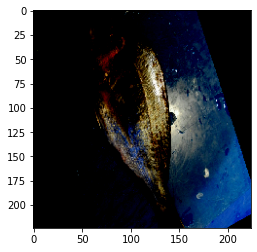

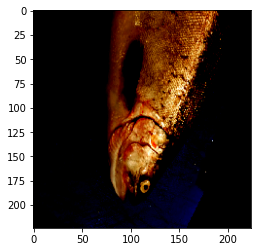

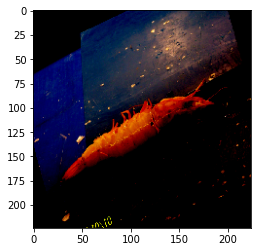

In [ ]:
for _ in range(5):
    img, label = x_train.next()
    plt.imshow(img[0])
    plt.show()

### Simple neural network 

The modelling approach is implemented by using the keras library of the tensorflow framework. In this simple neural network model, there are 3 layers: 2 of them have a relu function as activation function and one a softmax


In [ ]:
fc_model = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(113,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9,activation="softmax")
])

fc_model.compile(optimizer="adam",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fit = fc_model.fit(x_train,
                validation_data = x_val,
                epochs = 10, callbacks=Callback)

Epoch 1/10
211/211 [==============================] - 166s 784ms/step - loss: 2.0377 - accuracy: 0.2234 - val_loss: 1.7665 - val_accuracy: 0.3222
Epoch 2/10
211/211 [==============================] - 159s 753ms/step - loss: 1.7142 - accuracy: 0.3564 - val_loss: 1.5034 - val_accuracy: 0.4711
Epoch 3/10
211/211 [==============================] - 171s 810ms/step - loss: 1.5562 - accuracy: 0.4247 - val_loss: 1.4551 - val_accuracy: 0.4856
Epoch 4/10
211/211 [==============================] - 177s 839ms/step - loss: 1.4700 - accuracy: 0.4536 - val_loss: 1.3064 - val_accuracy: 0.5244
Epoch 5/10
211/211 [==============================] - 170s 807ms/step - loss: 1.4158 - accuracy: 0.4769 - val_loss: 1.2607 - val_accuracy: 0.5422
Epoch 6/10
211/211 [==============================] - 170s 805ms/step - loss: 1.3560 - accuracy: 0.5006 - val_loss: 1.2146 - val_accuracy: 0.5456
Epoch 7/10
211/211 [==============================] - 162s 765ms/step - loss: 1.3188 - accuracy: 0.5083 - val_loss: 1.2024 -

In [ ]:
print('Model summary :')
print()
fc_model.summary()

Model summary :

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, None, None)  0         
                                                                 
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 9) 

In [ ]:
test_accuracy = fc_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

43/43 [==============================] - 31s 724ms/step - loss: 0.9920 - accuracy: 0.6541
Test accuracy is :  65.40740728378296 %


The accuracy on the test set reach nearly 94%, which is not bad but could be a bit better. 

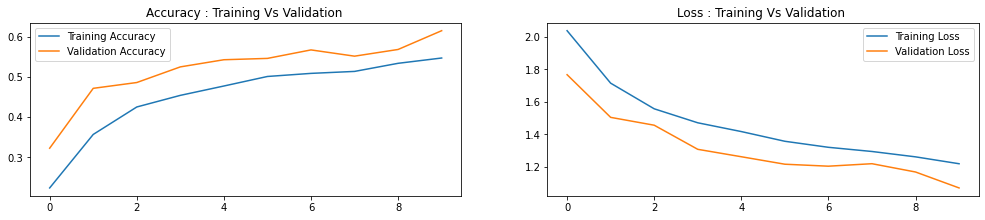

In [ ]:
accuracy = mo_fit.history['accuracy']
loss = mo_fit.history['loss']
validation_loss = mo_fit.history['val_loss']
validation_accuracy = mo_fit.history['val_accuracy']



plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()

  Regarding the accuracy, after 5 epochs the training accuracy is higher than the one of the validation set.The model is therefore subject to vanishing gradient. 

### Modelling with Resnet

An interesting question is: is there a way to improve the performance of the first modellimh apparoach with convolutional networks? 
As Resnet model enables to train a neural network with more than 150 layers, we can think that the accuracy will be improved  by using such a model.  

Resnet consists of hundreds of layers, this kind of neural network is very deep. Resnet are implemented with batch normalization and non linear functions such as Relu. But Resnet can be affected by the vanishing gradient phenomenon, indeed, the error rates during training increases significantly. To avoid this vanisshing gradient problem, the concept of residual blocks has been introduced, therefore the concept of "skip conections" is implemented. It means that some layers are akipped in between. Foe example, a Resnet 18  has 18 layers using these blocks. 

In [ ]:
from keras import applications
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.models import Sequential,Model,load_model

In [ ]:
img_height,img_width = 224, 224 
num_classes = 9
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = applications.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
model.compile(optimizer="adam",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

The Plot_model function enables us to see how the Resnet model looks like. As we can see below, the Resnet model is very deep and consists of many layers. 

In [ ]:
 tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.478672 to fit



In [ ]:
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
res_fit = model.fit(x_train,
                validation_data = x_val,
                epochs = 5, callbacks=Callback)

Epoch 1/10
211/211 [==============================] - 4283s 20s/step - loss: 1.6973 - accuracy: 0.4996 - val_loss: 9.4089 - val_accuracy: 0.1556
Epoch 2/10
211/211 [==============================] - 4155s 20s/step - loss: 0.5840 - accuracy: 0.8018 - val_loss: 8.9766 - val_accuracy: 0.2822
Epoch 3/10
211/211 [==============================] - 4103s 19s/step - loss: 0.3436 - accuracy: 0.8865 - val_loss: 2.0957 - val_accuracy: 0.5778
Epoch 4/10
211/211 [==============================] - 4262s 20s/step - loss: 0.2573 - accuracy: 0.9181 - val_loss: 0.6507 - val_accuracy: 0.8044
Epoch 5/10
211/211 [==============================] - 4154s 20s/step - loss: 0.1665 - accuracy: 0.9453 - val_loss: 1.2878 - val_accuracy: 0.6956
Epoch 6/10
 83/211 [==========>...................] - ETA: 41:02 - loss: 0.2213 - accuracy: 0.9334

In [ ]:
model.summary()

Model summary :



NameError: ignored

In [ ]:
test_accuracy = model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

In [ ]:
accuracy = res_fit.history['accuracy']
loss = res_fit.history['loss']
validation_loss = res_fit.history['val_loss']
validation_accuracy = res_fit.history['val_accuracy']


plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()

## Sources 




*   https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
*   https://builtin.com/artificial-intelligence/resnet-architecture
*   https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33
*   https://www.youtube.com/watch?v=57N1g8k2Hwc
*   https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
* https://www.kaggle.com/code/fahadmehfoooz/fish-analysis
* https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/
* https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb


 





